In [1]:
import os

In [2]:
computation = 'cloud'

In [3]:
if computation == 'cloud' :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud'
  model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models'
  data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
  seq_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/recent_seq_data_n100_valid_only'
  relevance_seq_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/relevance_seq_data_n100_valid_only'
  global_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel_1'
  recent_transformer_path = '/content/drive/MyDrive/uco_fraud_detector/models/best_2block_transformer_n100_model_1.keras'
  relevance_transformer_path = '/content/drive/MyDrive/uco_fraud_detector/models/best_relevance_transformer_n100_model_valid_only.keras'
else :
  data_path = '../data/transaction_fraud'
  model_save_path = '../models'
  data_preprocess_path = '../data/data_preprocess'
  seq_data_path = '../data/recent_seq_data_n100_valid_only'
  relevance_seq_data_path = '../data/relevance_seq_data_n100_valid_only'
  global_model_path = '../models/globalmodel_1'
  recent_transformer_path = '../models/best_2block_transformer_n100_model_1.keras'
  relevance_transformer_path = '../models/best_relevance_transformer_n100_valid_only.keras'

print("searching for data path" , "found" if os.path.exists(data_path) else "not found")
print(os.listdir(data_path))

Mounted at /content/drive
searching for data path found
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , auc , precision_recall_curve
from sklearn.model_selection import train_test_split


### ____

In [34]:
def evaluate_model(model,
                   model_name,
                   X_train,
                   Y_train,
                   X_test,
                   Y_test) :
    model.fit(X_train, Y_train)
    y_cap = model.predict(X_test)
    print(f'Evaluation_for {model_name}: ')
    print(classification_report(Y_test, y_cap))
    conf_mat = confusion_matrix(Y_test, y_cap)
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('y_cap')
    plt.ylabel('y_test')
    plt.show()

    #ROC curve and the area under curve
    y_score = model.predict_proba(X_test)[:,1]
    false_pos_rate , true_pos_rate, thr = roc_curve(Y_test, y_score)
    roc_auc = auc(false_pos_rate , true_pos_rate)

    plt.figure(figsize = (7,5))
    plt.plot(false_pos_rate, true_pos_rate, label = f'ROC Curve, area = {roc_auc:.3f}')
    plt.plot([0,1] , [0,1] , linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    #Precision-Recall curve Nad AUC
    precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()
    return model

In [5]:
@tf.keras.utils.register_keras_serializable()
class ExpandDims(layers.Layer):
    def __init__(self, **kwargs):
        super(ExpandDims, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.expand_dims(inputs, axis=-1)
    def get_config(self):
        config = super(ExpandDims, self).get_config()
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.2, name='multi_head_attention')
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4), name='dense_1'),
            layers.Dense(embed_dim, kernel_regularizer=keras.regularizers.l2(1e-4), name='dense_2')
        ], name='feed_forward_network')
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6, name='layer_norm_1')
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6, name='layer_norm_2')
        self.dropout1 = layers.Dropout(rate, name='dropout_1')
        self.dropout2 = layers.Dropout(rate, name='dropout_2')

    def call(self, inputs, training, mask=None):
        # Assuming inputs is the combined tensor after embedding and concatenation
        seq_len = tf.shape(inputs)[1]
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        causal_mask = tf.cast(causal_mask, tf.bool)

        # Get the mask from the input tensor (assuming masking was applied before)
        input_mask = self._compute_mask(inputs, mask=mask)
        if input_mask is not None:
            # Expand mask to be compatible with attention mask shape
            input_mask = tf.cast(input_mask, causal_mask.dtype)
            causal_mask = causal_mask & input_mask[:, tf.newaxis, :]

        norm1 = self.layernorm1(inputs)
        attn_output = self.att(norm1, norm1, attention_mask=causal_mask)
        current_transaction_bias = tf.zeros_like(attn_output)
        current_transaction_bias = current_transaction_bias[:, 0:1, :] + 0.1
        attn_output = attn_output + current_transaction_bias
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        norm2 = self.layernorm2(out1)
        ffn_output = self.ffn(norm2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    def _compute_mask(self, inputs, mask=None):
        # Compute mask based on the input tensor's mask if available
        return tf.keras.backend.get_value(inputs._keras_mask) if hasattr(inputs, '_keras_mask') else None




### ___

In [6]:
data_path = os.path.join(data_path, 'bs140513_032310.csv')

In [21]:
# df = pd.read_csv(data_path)

f = open(data_preprocess_path , 'rb')
data_preprocess = pickle.load(f)
f.close()

f = open(global_model_path , 'rb')
global_model = pickle.load(f)
f.close()

In [45]:
recent_transformer = tf.keras.models.load_model(recent_transformer_path)
relevance_transformer = tf.keras.models.load_model(relevance_transformer_path)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Recent transformer

In [ ]:
# f = open(seq_data_path , 'rb')
# seq_data = pickle.load(f)
# f.close()

In [9]:
global_model.feature_names_in_

array(['time_delta', 'age', 'gender', 'merchant_id', 'category', 'amount',
       'account_frequency', 'merchant_frequency'], dtype=object)

In [10]:
print("numerical cols : " , data_preprocess['NUMERICAL_COLS'])
print("categorical cols : " , data_preprocess['CATEGORICAL_COLS'])

numerical cols :  ['time_delta', 'account_frequency', 'merchant_frequency', 'amount']
categorical cols :  ['age', 'gender', 'merchant_id', 'category']


In [11]:
# train_num_seq = seq_data['sequences'][:, :, :len(data_preprocess['NUMERICAL_COLS'])]
# train_cat_seq = seq_data['sequences'][:, :, len(data_preprocess['NUMERICAL_COLS']):].astype(np.int32)
# y_train = seq_data['targets']

# # Prepare inputs
# X_train = {
#     'numerical_input': train_num_seq,
#     'age_input': train_cat_seq[:, :, 0],
#     'gender_input': train_cat_seq[:, :, 1],
#     'merchant_input': train_cat_seq[:, :, 2],
#     'category_input': train_cat_seq[:, :, 3]
# }

# BATCH_SIZE = 32

# # Ensure consistent data types for dataset creation
# numerical_input_dtype = tf.float32
# categorical_input_dtype = tf.int32
# target_dtype = np.float32 # Corrected to use np.float32

# # Reshape targets to be 2D
# y_train_reshaped = y_train[:, np.newaxis].astype(target_dtype)

# # Create TensorFlow Datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'numerical_input': tf.cast(X_train['numerical_input'], numerical_input_dtype),
#         'age_input': tf.cast(X_train['age_input'], categorical_input_dtype),
#         'gender_input': tf.cast(X_train['gender_input'], categorical_input_dtype),
#         'merchant_input': tf.cast(X_train['merchant_input'], categorical_input_dtype),
#         'category_input': tf.cast(X_train['category_input'], categorical_input_dtype)
#     },
#     y_train_reshaped
# )).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
# transformer_prediction = recent_transformer.predict(X_train , verbose = 1)

18583/18583 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


In [18]:
# del  X_train , y_train_reshaped , train_num_seq , train_cat_seq

In [22]:
# recon_df = pd.DataFrame(columns= global_model.feature_names_in_)
# # Get the first transaction from each sequence
# first_transactions = seq_data['sequences'][:, 0, :]
# # original indices: 0, 1, 2, 3, 4, 5, 6, 7
# # new indices:      0, 4, 5, 6, 7, 3, 1, 2
# reorganized_indices = [0, 4, 5, 6, 7, 3, 1, 2]
# # Reorganize the array using the defined indices
# reorganized_transactions = first_transactions[:, reorganized_indices]
# # Create the DataFrame using the reorganized array and the correct columns
# recon_df = pd.DataFrame(reorganized_transactions, columns=global_model.feature_names_in_)
# # Display the head of the optimized DataFrame to compare
# display(recon_df.head())

,time_delta,age,gender,merchant_id,category,amount,account_frequency,merchant_frequency
0,-1.272914,5.0,2.0,22.0,9.0,0.951322,-0.918953,-2.237926
1,-1.116216,5.0,2.0,15.0,10.0,-0.190302,-0.918953,-2.241786
2,-1.037867,5.0,2.0,22.0,9.0,0.164178,-0.918953,-2.237926
3,-1.018280,5.0,2.0,42.0,11.0,-0.207806,-0.918953,-2.233031
4,-0.998692,5.0,2.0,18.0,12.0,0.085544,-0.918953,0.765246


In [23]:
# global_fraud_prediction = global_model.predict_proba(recon_df)[: , 1]

In [30]:
# ensemble_df = pd.DataFrame(columns=['age' , 'gender' , 'category' , 'amount' ,'recent_transformer_fraud' , 'global_model_fraud' , 'fraud'])

# ensemble_df['age'] = recon_df['age']
# ensemble_df['gender'] = recon_df['gender']
# ensemble_df['category'] = recon_df['category']
# ensemble_df['amount'] = recon_df['amount']
# ensemble_df['recent_transformer_fraud'] = transformer_prediction
# ensemble_df['global_model_fraud'] = global_fraud_prediction
# ensemble_df['fraud'] = seq_data['targets']

In [40]:
# recent_ensemble_df_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/recent_ensemble_df'
# with open(recent_ensemble_df_save_path , 'wb') as f :
#   pickle.dump(ensemble_df , f)

In [41]:
recent_ensemble_df_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/recent_ensemble_df'
with open(recent_ensemble_df_save_path , 'rb') as f :
  ensemble_df = pickle.load(f)

In [31]:
X_train , X_test , y_train , y_test = train_test_split(ensemble_df.drop('fraud' , axis = 1) , ensemble_df['fraud'] , test_size=0.2 , random_state=42)

Evaluation_for MLP: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117483
           1       0.92      0.86      0.89      1446

    accuracy                           1.00    118929
   macro avg       0.96      0.93      0.94    118929
weighted avg       1.00      1.00      1.00    118929



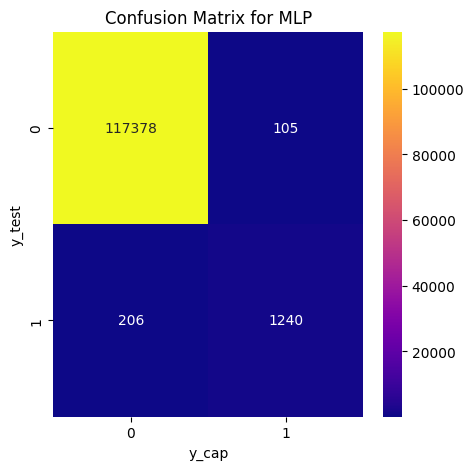

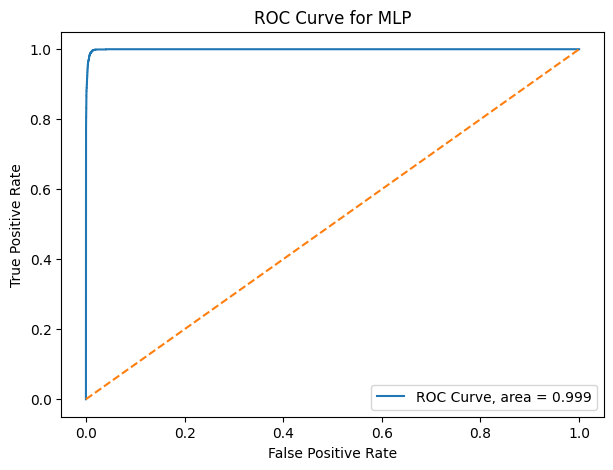

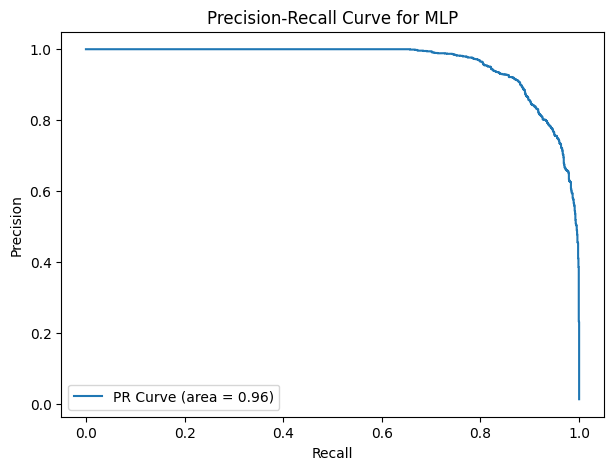

In [35]:
# import MLP
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(64, 100), activation='relu', solver='adam', random_state=42)
model = evaluate_model(model , 'MLP' , X_train , y_train , X_test , y_test)

In [39]:
# recent_ensemble_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/recent_ensemble_model'
# with open(recent_ensemble_save_path , 'wb') as f :
#   pickle.dump(model , f)

In [42]:
recent_ensemble_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/recent_ensemble_model'
with open(recent_ensemble_save_path , 'rb') as f :
  model = pickle.load(f)

In [44]:
# del ensemble_df , X_train , X_test , y_train , y_test , seq_data , model , recent_transformer , recon_df

### Relevance Transformer

In [46]:
with open(relevance_seq_data_path , 'rb') as f :
  seq_data = pickle.load(f)

In [47]:
global_model.feature_names_in_

array(['time_delta', 'age', 'gender', 'merchant_id', 'category', 'amount',
       'account_frequency', 'merchant_frequency'], dtype=object)

In [48]:
print("numerical cols : " , data_preprocess['NUMERICAL_COLS'])
print("categorical cols : " , data_preprocess['CATEGORICAL_COLS'])

numerical cols :  ['time_delta', 'account_frequency', 'merchant_frequency', 'amount']
categorical cols :  ['age', 'gender', 'merchant_id', 'category']


In [51]:
seq_data['sequences'][0][0]

array([-1.2729139 , -0.91895294, -2.237926  ,  0.9513219 ,  5.        ,
        2.        , 22.        ,  9.        ], dtype=float32)

In [57]:
recon_df = pd.DataFrame(columns= global_model.feature_names_in_)
# Get the first transaction from each sequence
first_transactions = seq_data['sequences'][:, 0, :]
# original indices: 0, 1, 2, 3, 4, 5, 6, 7
# new indices:      0, 4, 5, 6, 7, 3, 1, 2
reorganized_indices = [0, 4, 5, 6, 7, 3, 1, 2]
# Reorganize the array using the defined indices
reorganized_transactions = first_transactions[:, reorganized_indices]
# Create the DataFrame using the reorganized array and the correct columns
recon_df = pd.DataFrame(reorganized_transactions, columns=global_model.feature_names_in_)
# Display the head of the optimized DataFrame to compare
display(recon_df.head())

,time_delta,age,gender,merchant_id,category,amount,account_frequency,merchant_frequency
0,-1.272914,5.0,2.0,22.0,9.0,0.951322,-0.918953,-2.237926
1,-1.116216,5.0,2.0,15.0,10.0,-0.190302,-0.918953,-2.241786
2,-1.037867,5.0,2.0,22.0,9.0,0.164178,-0.918953,-2.237926
3,-1.018280,5.0,2.0,42.0,11.0,-0.207806,-0.918953,-2.233031
4,-0.998692,5.0,2.0,18.0,12.0,0.085544,-0.918953,0.765246


In [53]:
global_fraud_prediction = global_model.predict_proba(recon_df)[: , 1]

In [55]:
X_train = seq_data['sequences']
y_train = seq_data['targets']
relevance_train = seq_data['relevance_scores']

train_num_seq = X_train[:, :, :len(data_preprocess['NUMERICAL_COLS'])]
train_cat_seq = X_train[:, :, len(data_preprocess['NUMERICAL_COLS']):].astype(np.int32)

X_train = {
    'numerical_input': train_num_seq,
    'age_input': train_cat_seq[:, :, 0],
    'gender_input': train_cat_seq[:, :, 1],
    'merchant_input': train_cat_seq[:, :, 2],
    'category_input': train_cat_seq[:, :, 3],
    'relevance_input': relevance_train
}

BATCH_SIZE = 32
y_train_reshaped = y_train[:, np.newaxis].astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'numerical_input': tf.cast(X_train['numerical_input'], tf.float32),
        'age_input': tf.cast(X_train['age_input'], tf.int32),
        'gender_input': tf.cast(X_train['gender_input'], tf.int32),
        'merchant_input': tf.cast(X_train['merchant_input'], tf.int32),
        'category_input': tf.cast(X_train['category_input'], tf.int32),
        'relevance_input': tf.cast(X_train['relevance_input'], tf.float32)
    },
    y_train_reshaped
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [56]:
relevance_transformer_fraud = relevance_transformer.predict(X_train , verbose = 1)

18583/18583 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step


In [58]:
ensemble_df = pd.DataFrame(columns=['age' , 'gender' , 'category' , 'amount' ,'relevance_transformer_fraud' , 'global_model_fraud' , 'fraud'])
ensemble_df['age'] = recon_df['age']
ensemble_df['gender'] = recon_df['gender']
ensemble_df['category'] = recon_df['category']
ensemble_df['amount'] = recon_df['amount']
ensemble_df['relevance_transformer_fraud'] = relevance_transformer_fraud
ensemble_df['global_model_fraud'] = global_fraud_prediction
ensemble_df['fraud'] = seq_data['targets']

In [63]:
emsemble_data_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/relevance_ensemble_df'
with open(emsemble_data_save_path , 'wb') as f :
  pickle.dump(ensemble_df , f)

In [64]:
ensemble_data_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/relevance_ensemble_df'
with open(emsemble_data_save_path , 'rb') as f :
  ensemble_df = pickle.load(f)

In [59]:
X_train , X_test , y_train , y_test = train_test_split(ensemble_df.drop('fraud' , axis = 1) , ensemble_df['fraud'] , test_size=0.2 , random_state=42)

Evaluation_for MLP: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117483
           1       0.93      0.88      0.90      1446

    accuracy                           1.00    118929
   macro avg       0.96      0.94      0.95    118929
weighted avg       1.00      1.00      1.00    118929



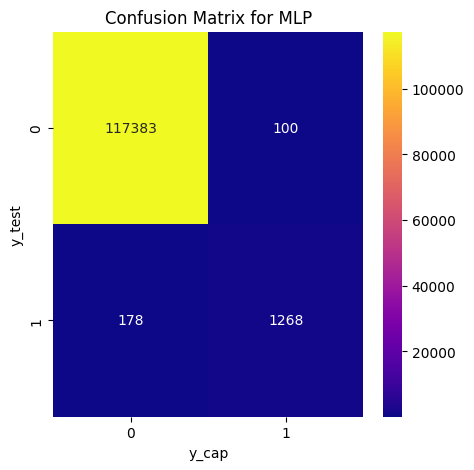

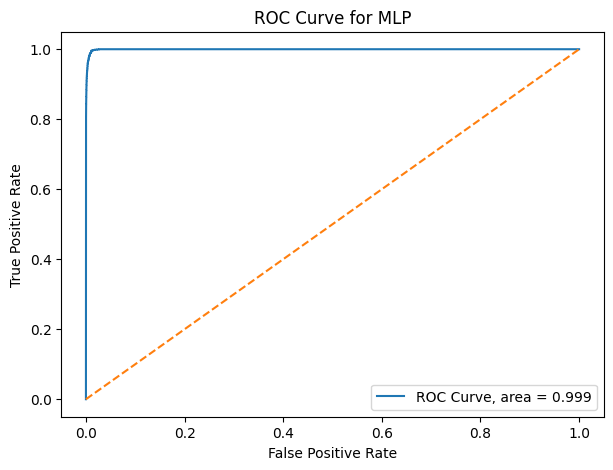

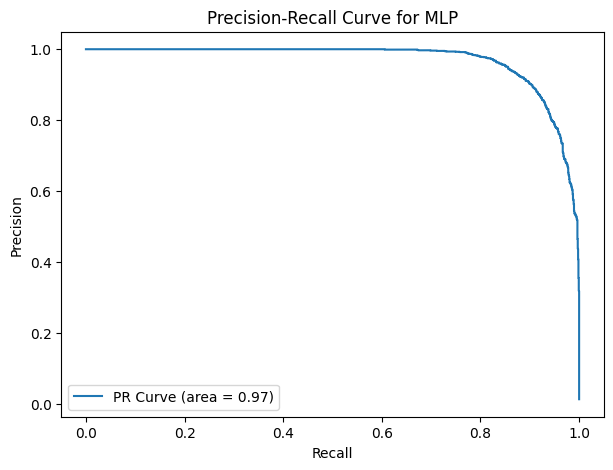

In [60]:
model = MLPClassifier(hidden_layer_sizes=(64, 100), activation='relu', solver='adam', random_state=42)
model = evaluate_model(model , 'MLP' , X_train , y_train , X_test , y_test)

In [61]:
# embsemble_model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/relevance_ensemble_model'
# with open(embsemble_model_save_path , 'wb') as f :
#   pickle.dump(model , f)

In [62]:
ensemble_model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/relevance_ensemble_model'
with open(ensemble_model_save_path , 'rb') as f :
  model = pickle.load(f)